# Trends and Analysis of eCommerce Data

## CSPB 4502 Spring 2024 - Group 9

Francesca Barrios   
frba7936@colorado.edu

Laura Brown   
labr1398@colorado.edu

Seth Ely  
seel6470@colorado.edu

Darby Hansen  
daha2377@colorado.edu 

## Data Cleaning

The first step is to download the dataset into a useable format with this notebook using the Pandas library. This is easier said than done, since the data for each month is about 2 to 3 Gb each in its compressed form, and joining the data into one dataframe is causing the kernel to crash.

To begin with, we can create a sample dataset from the entire dataset locally and upload that file to our github repo.

In [2]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt


_(markdown cell since data files are stored locally and code will fail if run in environment)_

```python
# List of file names for each dataset month
local_file_paths = [
    './2019-Oct.csv.gz',
    './2019-Nov.csv.gz',
    './2019-Dec.csv.gz',
    './2020-Jan.csv.gz',
    './2020-Feb.csv.gz',
    './2020-Mar.csv.gz',
    './2020-Apr.csv.gz'
]

sample_df = pd.DataFrame()

for file_path in local_file_paths:
    sample_df = pd.concat([sample_df, pd.read_csv(file_path, compression='gzip').sample(n=50000)])

# Write sampled data to a new CSV file
sample_df.to_csv('./all_months_sampled.csv.gz', index=False, compression='gzip')
```

We can then find some preliminary information using this sample dataset.

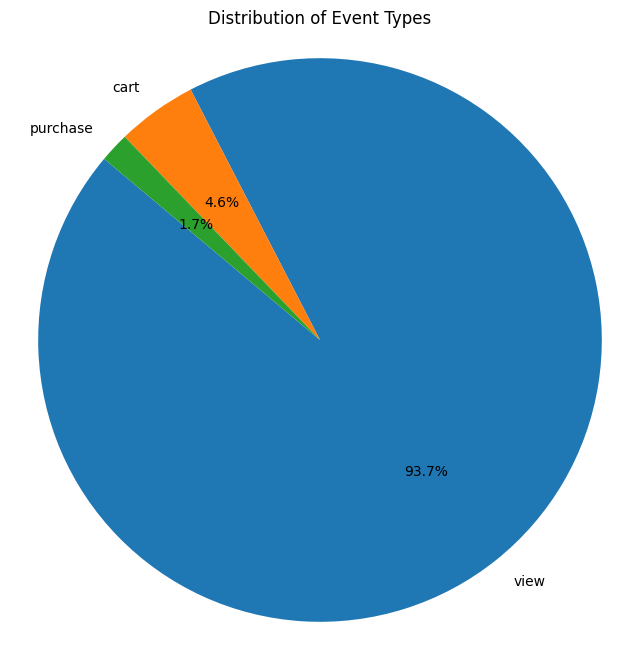

In [3]:
sample_df = pd.read_csv('./all_months_sampled.csv.gz',compression='gzip')

event_counts = sample_df['event_type'].value_counts()


plt.figure(figsize=(8, 8))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Event Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

An important understanding of our dataset is that the event_types are mostly views, with a very minor percentage being purchases. Since most of our questions involve looking specifically at purchases, we can use this information to reduce the size of the dataset. We can iterate through each local file again, this time only taking entries where the event_types are 'purchase'

_(markdown cell since data files are stored locally and code will fail if run in environment)_

```python
purchased_entries = pd.DataFrame()

# List of file names for each month
file_paths = [
    './2019-Oct.csv.gz',
    './2019-Nov.csv.gz',
    './2019-Dec.csv.gz',
    './2020-Jan.csv.gz',
    './2020-Feb.csv.gz',
    './2020-Mar.csv.gz',
    './2020-Apr.csv.gz'
]

for file_path in file_paths:
    cur_df = pd.read_csv(file_path, compression='gzip')
    purchased_entries = pd.concat([purchased_entries, cur_df[cur_df['event_type'] == 'purchase']], ignore_index=True)


# Write to csv.gz
purchased_entries.to_csv('purchased_entries.csv.gz', compression='gzip')
```

This dataframe is still fairly massive and might need to be iterated over in chunks to avoid overflowing memory in online environments especially. Because of this, we can use the 'chunksize' attribute of pd.read_csv to iterate over it in chunks. Let's do this to gain further insight about NaN values

In [6]:
chunksize = 100000

nan_accum = pd.Series(dtype='float64')
len_accum = 0
for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=chunksize):
    len_accum += len(chunk)
    nan_accum = nan_accum.add(chunk.isnull().sum(), fill_value=0)

FileNotFoundError: [Errno 2] No such file or directory: './purchased_entries.csv.gz'

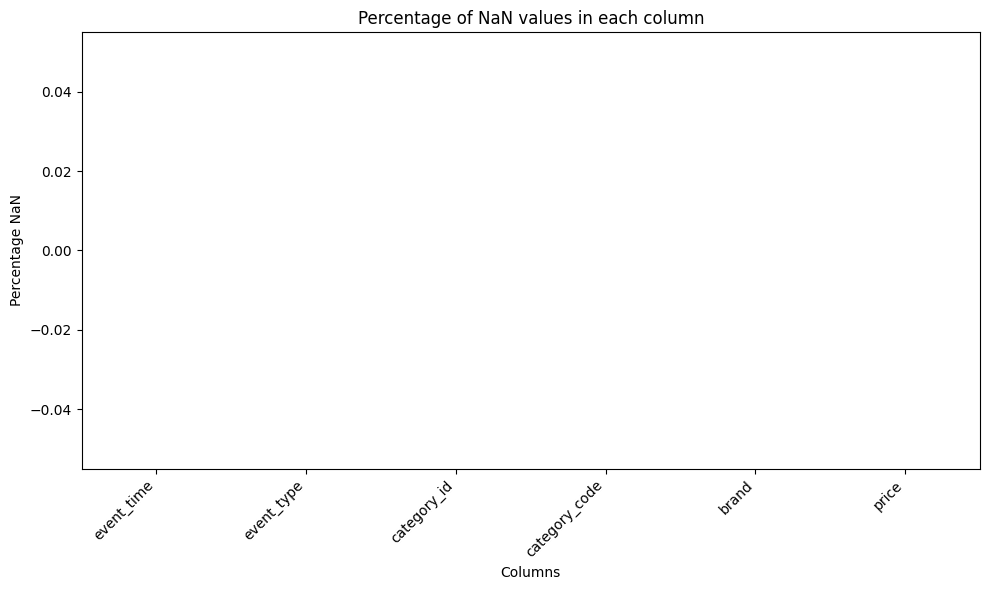

KeyError: 'user_session'

In [5]:
plt.figure(figsize=(10, 6))
(100* nan_accum/len_accum).plot(kind='bar', color='skyblue')
plt.title('Percentage of NaN values in each column')
plt.xlabel('Columns')
plt.ylabel('Percentage NaN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print('There are',nan_accum['user_session'],'user_session NaNs')

We can see that 7.7% of all brands are made up by NaN values and 11% of category codes are NaNs. There are a very small amount of user_session data points that are NaN as well, but these are negligible. It would be helpful to determine how many entries have both NaN category_codes and NaN brand features.

In [6]:
chunksize = 100000
cat_and_brand_nans = 0
len_accum = 0

# Iterate through the CSV file in chunks
for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=chunksize):
    # Count the total number of rows in the chunk
    len_accum += len(chunk)
    
    # Filter the chunk to include only rows where both 'category_code' and 'brand' are NaN
    cat_and_brand_nans += (chunk['category_code'].isna() & chunk['brand'].isna()).sum()


In [7]:
brand_no_cat = nan_accum['category_code']-cat_and_brand_nans
cat_no_brand = nan_accum['brand']-cat_and_brand_nans
valid_brand_and_cat = len_accum - (brand_no_cat+cat_no_brand+cat_and_brand_nans)
table = pd.DataFrame(
    {
        'Valid category_code': [valid_brand_and_cat, nan_accum['brand']-cat_and_brand_nans],
        'NaN category_code': [brand_no_cat,cat_and_brand_nans]
    },
    index=['Valid brand','NaN brand']
)
table['Total'] = table.sum(axis=1)
table.loc['Total'] = table.sum(axis=0)
table.applymap('{:,.0f}'.format)

,Valid category_code,NaN category_code,Total
Valid brand,"5,707,926","611,751","6,319,677"
NaN brand,"372,838","156,309","529,147"
Total,"6,080,764","768,060","6,848,824"


In [8]:
# create dataframe to show this as a 2x2 table (columns not NaN, Nan; rows: category_code, brand)

print('percentage across all category_code NaNs that also have NaN brand:',100* cat_and_brand_nans / nan_accum['category_code'],'%')
print('percentage across all Brand values that have a NaN value and a valid category_code:', 100*(nan_accum['brand'] - cat_and_brand_nans)/ len_accum,'%')
print('percentage across all category_code values that have a NaN value and a valid brand value:', 100*(nan_accum['category_code'] - cat_and_brand_nans)/ len_accum,'%')

percentage across all category_code NaNs that also have NaN brand: 20.351144441840482 %
percentage across all Brand values that have a NaN value and a valid category_code: 5.443825100484404 %
percentage across all category_code values that have a NaN value and a valid brand value: 8.932205003369921 %


It looks like 20% of the category_code NaN entries also do not have the brand value. Since these entries would have only the product_id to go off of (a numerical categorical value that has little meaning) we can safely drop these values as they would have little information for us.

With this in mind, only 5% of all remaining brand entries will have valid category codes and only 9% of all remaining category_code entries will have a valid brand value. Because of this, we may be able to remove any NaNs for category_code, brand, and user_session while still retaining a vast majority of the variability of our data.

Our group also discussed the relevance of the user_id and user_session features as they would not hold relevant to many of the questions we are seeking to answer. Furthermore, the product_id feature seems to hold a numerical value, which without knowing what online vendor this data is from, is not very helpful in determining the associated product.

_(this code seems to not work in the online version of JupyterHub, but it can be run offline)_
```python
purchased_entries = pd.DataFrame()

for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=100000):
    purchased_entries = pd.concat([purchased_entries, chunk.drop(columns=['user_id','user_session','product_id']).dropna()])

# Write over purchased_entries.csv.gz
purchased_entries.to_csv('purchased_entries.csv.gz', compression='gzip', index=False)
```

We will also need to convert the event_time column from a string data type to a datetime type to gain insight into purchases over time and be able to create graphs using this column.

```python
purchased_entries = pd.DataFrame()

for chunk in pd.read_csv('./purchased_entries.csv.gz', chunksize=100000):
    # Convert 'event_time' column to datetime format
    chunk['event_time'] = pd.to_datetime(chunk['event_time'])
    purchased_entries = pd.concat([purchased_entries, chunk])

# Write over purchased_entries.csv.gz
purchased_entries.to_csv('purchased_entries_clean.csv.gz', compression='gzip', index=False)
```

With these changes, our data is now clean and ready to be worked with.

In [7]:
cleaned_dataset_head = pd.read_csv('./purchased_entries_clean.csv.gz', chunksize=5).get_chunk()
cleaned_dataset_head

,event_time,event_type,category_id,category_code,brand,price
0,2019-10-01 00:02:14+00:00,purchase,2053013555631882655,electronics.smartphone,samsung,130.76
1,2019-10-01 00:04:37+00:00,purchase,2053013555631882655,electronics.smartphone,apple,642.69
2,2019-10-01 00:07:07+00:00,purchase,2053013557418656265,furniture.bathroom.toilet,santeri,54.42
3,2019-10-01 00:09:26+00:00,purchase,2053013554658804075,electronics.audio.headphone,apple,189.91
4,2019-10-01 00:09:54+00:00,purchase,2053013554658804075,electronics.audio.headphone,apple,161.98


# Since the cleaned csv.gz file cannot be uploaded, we have provided a [link to it here](https://o365coloradoedu-my.sharepoint.com/:u:/g/personal/seel6470_colorado_edu/ESA7CLIV9o9GofliJhF4M7kBY_G1lR-JuUPj6CaiO0OQBg?e=XSJqss)

___________________________________

# Analysis of the Cleaned Data

## Question 1: Which brands, or item categories, exhibit the highest volume of sales during the specified period?
Now that the data has been cleaned we can create an accurate dataframe with the categoy codes and brands for all entries. Below we have created a frequency bar plot for the data. Since we are looking at which item/brand has the highest frequency, the visualizations have been truncated to improve clarity.

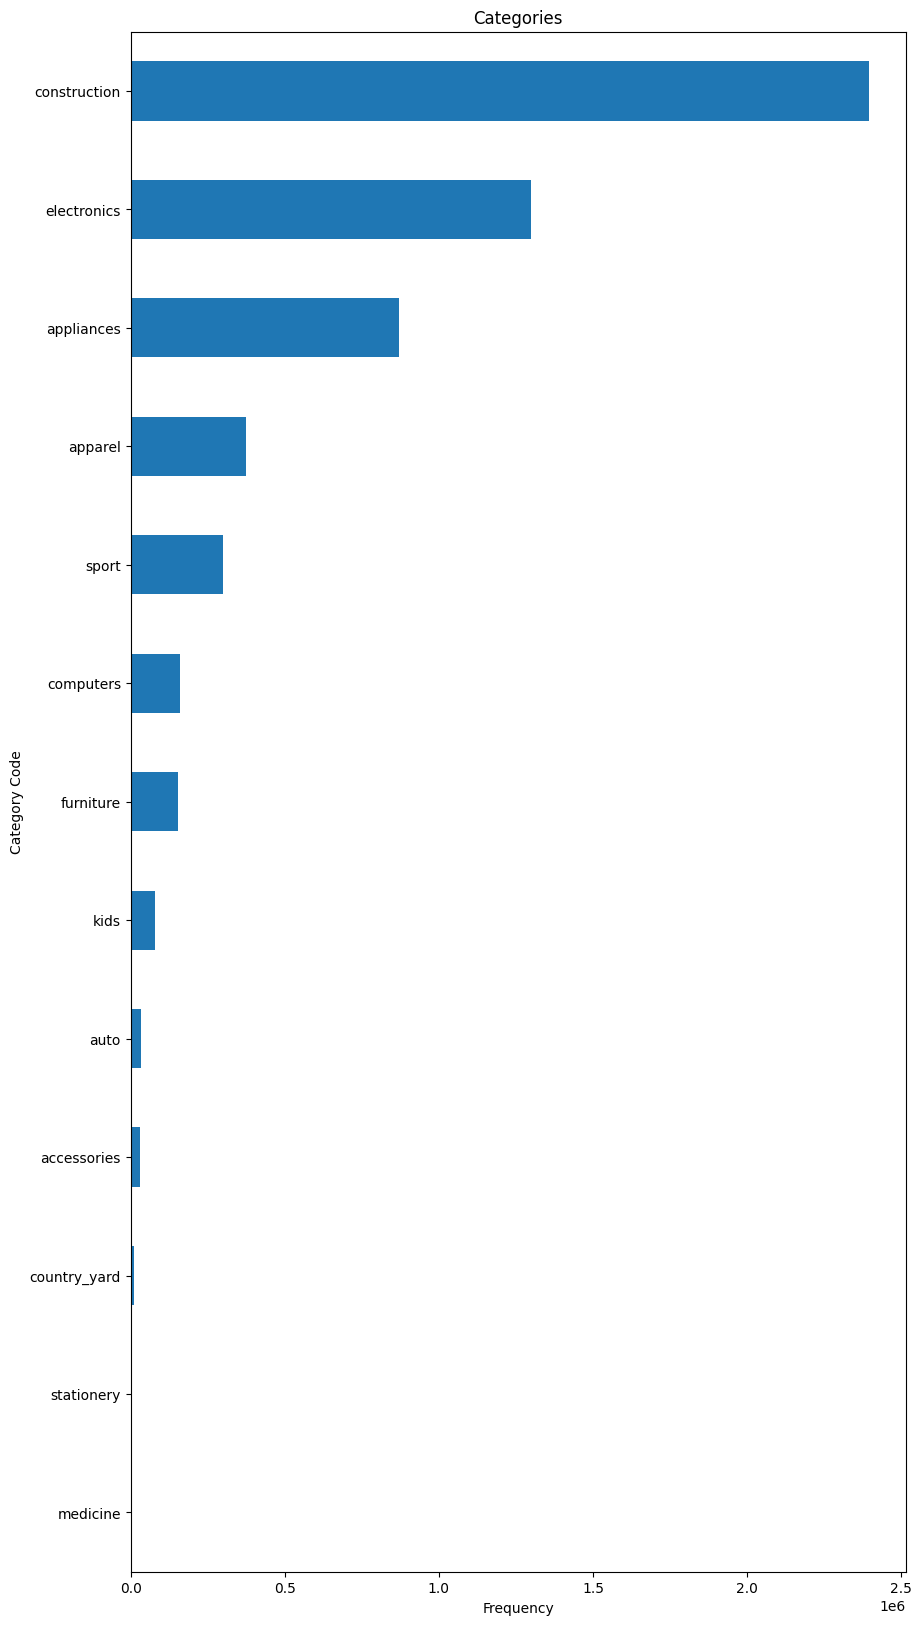

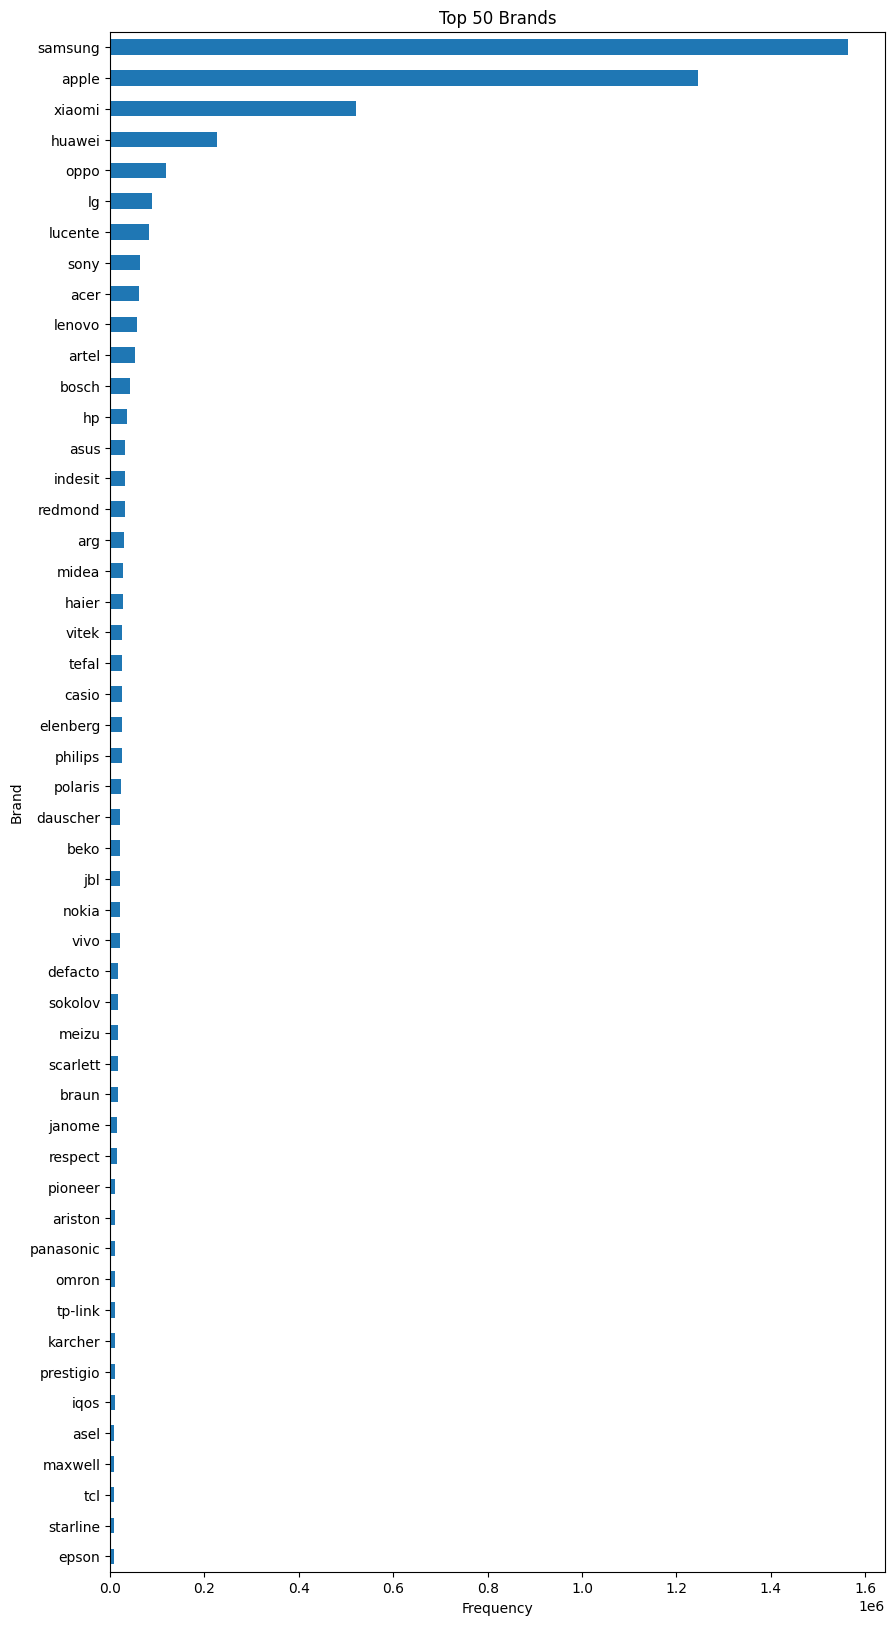

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

#initialize dataframe of the cleaned data
df = pd.read_csv('./purchased_entries_clean.csv.gz')

# Calculate the frequency of each category code
#category_counts = df['category_code'].value_counts()
df['main_category'] = df['category_code'].str.split('.').str[0]

# Group by 'main_category' and count occurrences
category_counts = df.groupby('main_category').value_counts()
sorted_categories = category_counts.sort_values(ascending=False)

#truncate values to top values
#top_categories = category_counts.head(50)

# Plot a horizontal bar chart
#plt.figure(figsize=(10, 20))
#top_categories.plot(kind='barh')
#sorted_categories.plot(kind='barh')
#plt.title('Top 50 Category Codes')
#plt.xlabel('Frequency')
#plt.ylabel('Category Code')
#plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency at the top
#plt.show()

# Calculate the frequency of each category code
df['main_category'] = df['category_code'].str.split('.').str[0]

# Group by 'main_category' and count occurrences
category_counts = df['main_category'].value_counts()

# Sort the category counts by frequency in descending order
category_counts_sorted = category_counts.sort_values(ascending=False)

# Plot a horizontal bar chart
plt.figure(figsize=(10, 20))
category_counts_sorted.plot(kind='barh')
plt.title('Categories')
plt.xlabel('Frequency')
plt.ylabel('Category Code')
plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency at the top
plt.show()

# Calculate the frequency of each brand
brand_counts = df['brand'].value_counts()

#truncate values to top values
top_brands = brand_counts.head(50)

#Plot a horizontal bar chart
plt.figure(figsize=(10, 20))
top_brands.plot(kind='barh')
plt.title('Top 50 Brands')
plt.xlabel('Frequency')
plt.ylabel('Brand')
plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency at the top
plt.show()

From the first plot we can see the plurality of all purchases, in regards to item category, over the seven month period is the construction category. The second closest is electronics. In the second plot it is clear that Samsung has the highest volume of sales, closely followed by Apple products.

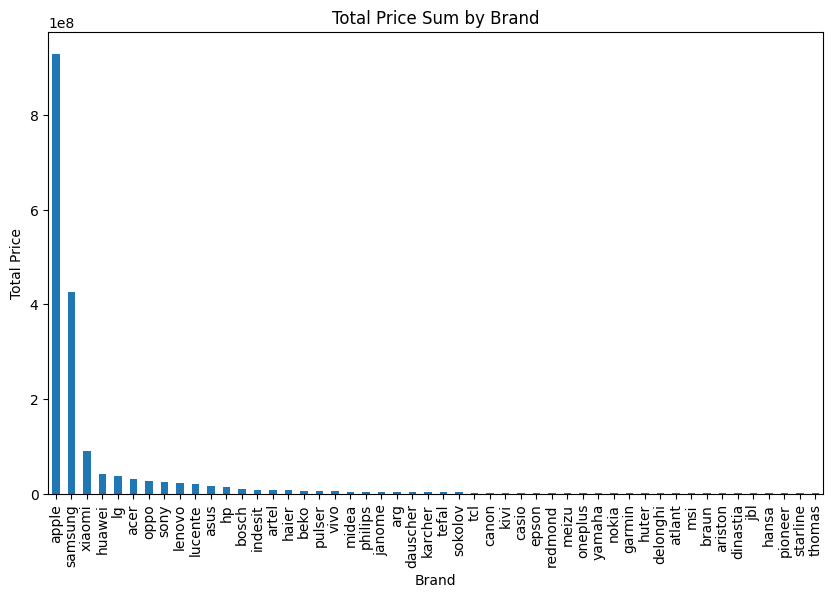

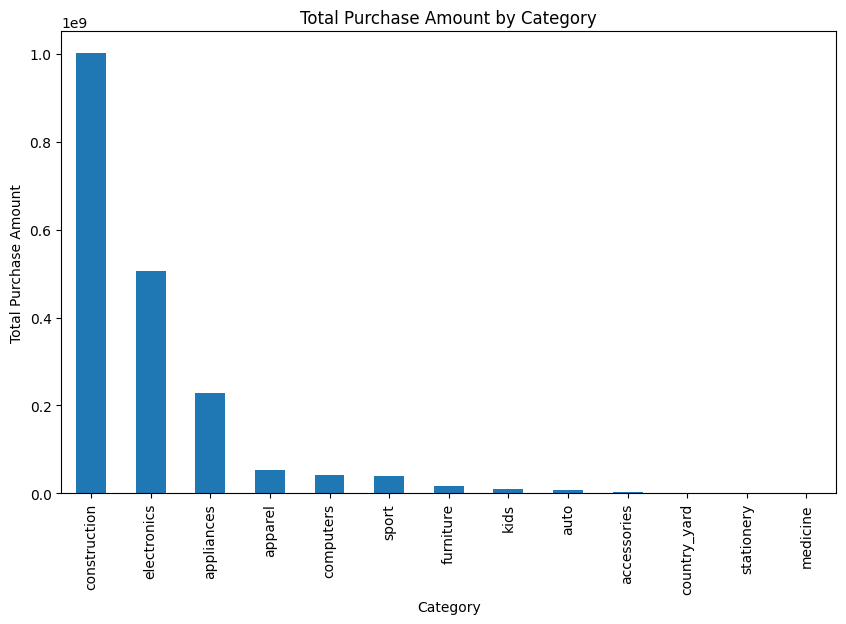

In [5]:
import matplotlib.pyplot as plt

# Group by 'brand' and calculate the sum of 'price'
brand_grouped = df.groupby('brand')['price'].sum().sort_values(ascending = False)
most_profitable_brand = brand_grouped.head(50)

# Group by 'category_code' and calculate the sum of 'price'

category_grouped = df.groupby('main_category')['price'].sum().sort_values(ascending = False)
#most_profitable_category = category_grouped.head(50)

# Plot for most profitable brand
plt.figure(figsize=(10, 6))
most_profitable_brand.plot(kind='bar')
plt.xlabel('Brand')
plt.ylabel('Total Price')
plt.title('Total Price Sum by Brand')
plt.show()


# Plot for most profitable category
plt.figure(figsize=(10, 6))
#most_profitable_category.plot(kind='bar')
category_grouped.plot(kind='bar')
plt.title('Total Purchase Amount by Category')
plt.xlabel('Category')
plt.ylabel('Total Purchase Amount')
plt.show()

After grouping the data by brand and category code, we took the total sum for each and compared them to the other brands and categories. The visualizations above show that the most profitable brand is Apple and the most profitable category is construction.tools.light.

### Are there discernible trends in sales across different brands and categories over the 7 month period? 

First we convert the 'event_time' category into a true datetime format.

In [58]:
# turn event_time into true datetime format
df['event_time'] = pd.to_datetime(df['event_time'])

# create two new columns, date and time with parsed data
df['date'] = df['event_time'].dt.date
df['time'] = df['event_time'].dt.time
df.head()

,event_time,event_type,category_id,category_code,brand,price,date,time
0,2019-10-01 00:02:14+00:00,purchase,2053013555631882655,electronics.smartphone,samsung,130.76,2019-10-01,00:02:14
1,2019-10-01 00:04:37+00:00,purchase,2053013555631882655,electronics.smartphone,apple,642.69,2019-10-01,00:04:37
2,2019-10-01 00:07:07+00:00,purchase,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,2019-10-01,00:07:07
3,2019-10-01 00:09:26+00:00,purchase,2053013554658804075,electronics.audio.headphone,apple,189.91,2019-10-01,00:09:26
4,2019-10-01 00:09:54+00:00,purchase,2053013554658804075,electronics.audio.headphone,apple,161.98,2019-10-01,00:09:54


### Among the features of brands, items, or item categories, which ones demonstrate the highest purchases per view ratio? 

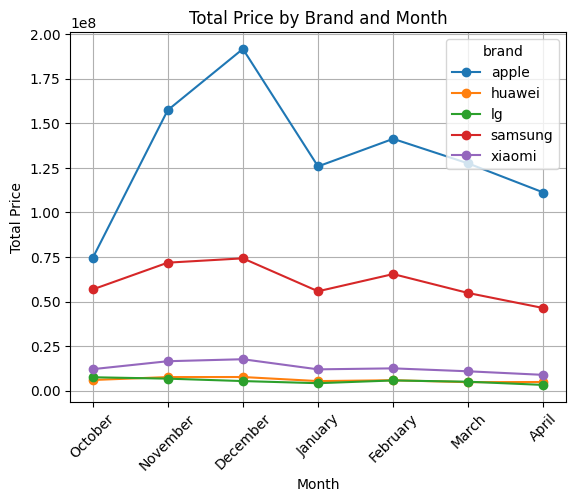

TypeError: no numeric data to plot

In [82]:
# Extract month from date column
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
months_ordered = ['October', 'November', 'December', 'January', 'February', 'March', 'April']

# For brand_grouped truncated brands to 5 most profitable brands
most_profitable_5_brands = brand_grouped.head(5)

# Extract months
df_top_5_brands = df[df['brand'].isin(most_profitable_5_brands.index)]
df_top_5_brands.loc[:, 'month'] = df_top_5_brands['date'].dt.strftime('%B')  # Full month name

# Group by brand and month and calculate the sum of price
brand_monthly_total = df_top_5_brands.groupby(['brand', 'month'])['price'].sum().reset_index()

# For category_grouped truncated category to 5 most profitable categories
most_profitable_5_categories = category_grouped.head(5)

# Extract months
df_top_5_categories = df[df['brand'].isin(most_profitable_5_categories.index)]
df_top_5_categories.loc[:, 'month'] = df_top_5_categories['date'].dt.strftime('%B')

category_monthly_total = df_top_5_categories.groupby(['brand', 'month'])['price'].sum().reset_index()

# Plot most profitable brand purchases over time

# Creates a dataframe suitable for plotting
pivot_df_brands = brand_monthly_total.pivot(index='month', columns='brand', values='price')
pivot_df_brands.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Price')
plt.title('Total Price by Brand and Month')
plt.xticks(range(len(months_ordered)), months_ordered, rotation=45) 
plt.grid(True)
plt.show()


# Plot most profitable category purchases over time
pivot_df_categories = category_monthly_total.pivot(index='month', columns='brand', values='price')
pivot_df_categories.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Price')
plt.title('Total Price by Category and Month')
plt.xticks(range(len(months_ordered)), months_ordered, rotation=45) 
plt.grid(True)
plt.show()

### What factors contribute to the rate of purchases per view of these brands, items, or item categories? 

In [ ]:
# Interpret

### Can brand type lead to customer retention (customer’s purchase frequency after initial purchase)? 

In [ ]:
import seaborn as sns

# Step 1: Find the top brands
top_brands = df['brand'].value_counts().head(5).index  # Change '5' to the number of top brands you want

# Step 2: Create subplots for each top brand
fig, axes = plt.subplots(len(top_brands), 1, figsize=(10, 8), sharex=True)

# Step 3: Plot histograms for each top brand
for i, brand in enumerate(top_brands):
    # Filter dataframe for the current brand
    brand_df = df[df['brand'] == brand]
    
    # Group by user_id and count the number of purchases
    purchase_count_per_user = brand_df.groupby('user_id').size()
    
    # Calculate the percentage of purchases for the current brand over all purchases by each user
    percentage_per_user = (purchase_count_per_user / df.groupby('user_id').size()) * 100
    
    # Plot histogram
    sns.histplot(percentage_per_user, bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Percentage of Users that Bought {brand} Over All Purchases')
    axes[i].set_xlabel('Percentage of Purchases')
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

### Can seasonal patterns be identified within the 7-month window of the dataset? 

In [ ]:
# filter by purchased


# graph top brands/categories over time
# (day/week/month whichever works best considering the large amount of entries)

### How do seasonal variations impact the sales and purchasing behaviors of consumers across individual brands and categories? 

### Can we find any trending patterns within our item sets outside of seasonal trend behavior – which can be used to predict popularity purchase windows? 

## Evaluation

### Accuracy

A useful insight into this data set would be to create a cluster algorithm to create groups of similar products. This could be helpful to determine a recommendation list on any given product page based on products that are also in the same cluster as the product being viewed.

We can do this using the K-Means algorithm with all category_code and brand pairings. First, let us get a list of all unique category_codes as well as brands:

Let's use the indices of each value to enable us to visualize the data points in our cleaned data set in a coordinate plane.

In [10]:
unique_value_pairs = pd.DataFrame()
for chunk in pd.read_csv('./purchased_entries_clean.csv.gz', compression='gzip', chunksize=100000):
    unique_value_pairs = pd.concat([unique_value_pairs, chunk[['category_code', 'brand']].drop_duplicates()])

In [11]:
unique_value_pairs

,category_code,brand
0,electronics.smartphone,samsung
1,electronics.smartphone,apple
2,furniture.bathroom.toilet,santeri
3,electronics.audio.headphone,apple
6,appliances.environment.air_heater,oasis
...,...,...
5707822,apparel.shoes,panasonic
5707829,construction.tools.welding,rock
5707830,electronics.camera.photo,xiaomi
5707875,apparel.shoes.keds,peg-perego


Since similar brands will be close together, and similar category_codes will be close together, let's assing numerical values based on alphabetical order that will allow us to visualize the two feature set in a coordinate plane.

In [12]:
x_axis_categories = unique_value_pairs['category_code'].unique()
x_axis_categories.sort()
x_axis_categories = pd.DataFrame(x_axis_categories,columns=['category_code'])
x_axis_categories

,category_code
0,accessories.bag
1,accessories.umbrella
2,accessories.wallet
3,apparel.belt
4,apparel.costume
...,...
134,sport.snowboard
135,sport.tennis
136,sport.trainer
137,stationery.cartrige


In [13]:
y_axis_brands = unique_value_pairs['brand'].unique()
y_axis_brands.sort()
y_axis_brands = pd.DataFrame(y_axis_brands,columns=['brand'])
y_axis_brands

,brand
0,a-case
1,a-derma
2,a-elita
3,a-mega
4,a-toys
...,...
4076,zte
4077,zubr
4078,zuru
4079,zvezda


### ToDo:
#### Create coordinate pairs using the indices from the corresponding x and y dataframes above

### Relevance

_discuss findings in terms of real-word needs_

### Interpretability

_discuss visualizations and how understandable the findings are to the general public_